# 1. Configuration et Importation des Bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


# 2. Chargement et Aperçu des Données

In [2]:
# 1. Charger les données
df = pd.read_csv("/content/insurance.csv")

In [3]:
# 2. Exploration des données (EDA) - ÉTAPE MANQUANTE
print("Informations sur le dataset:")
print(df.info())
print("\nStatistiques descriptives:")
print(df.describe())


Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Statistiques descriptives:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%  

In [4]:
# 3. Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())



Valeurs manquantes par colonne :
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# 3. Prétraitement des Données
## 3.1 Encodage des Variables Catégorielles

In [5]:
# 4. Encoder les variables catégoriques AVANT les visualisations
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df = pd.get_dummies(df, columns=['region'], prefix='region')


# 4. Analyse Exploratoire des Données (EDA)
## 4.1 Distribution de la Variable Cible

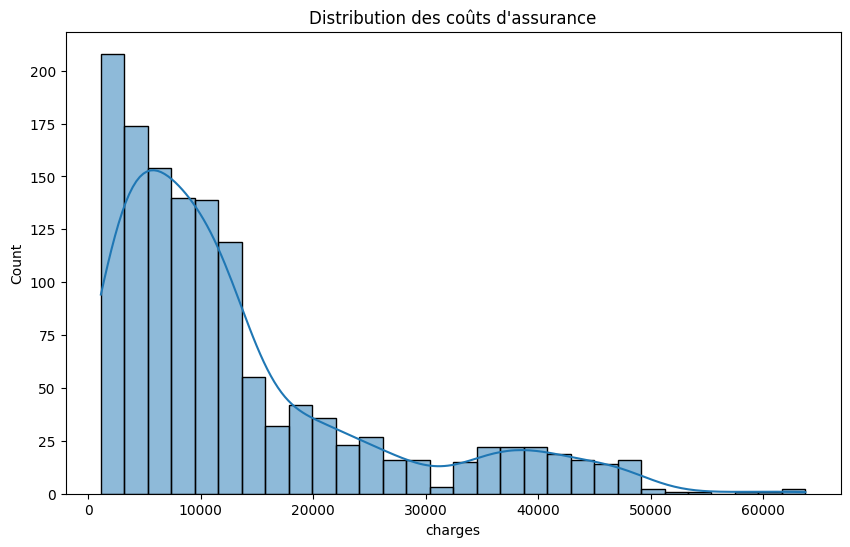

In [6]:
# Visualiser la distribution de la variable cible
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True)
plt.title('Distribution des coûts d\'assurance')
plt.show()


## 4.2 Matrice de Corrélation

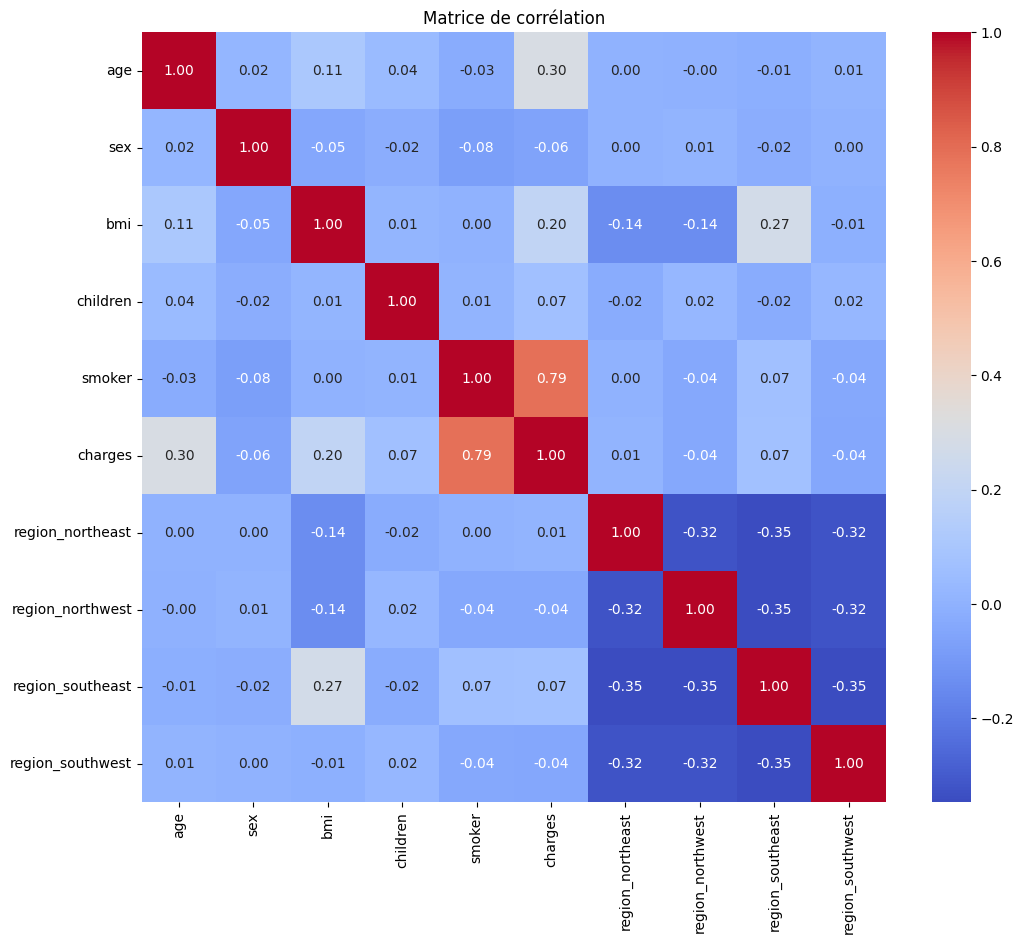

In [7]:
# Visualiser les relations entre variables
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()


## 4.3 Relations entre Variables et Coûts d'Assurance

<Figure size 1800x1200 with 0 Axes>

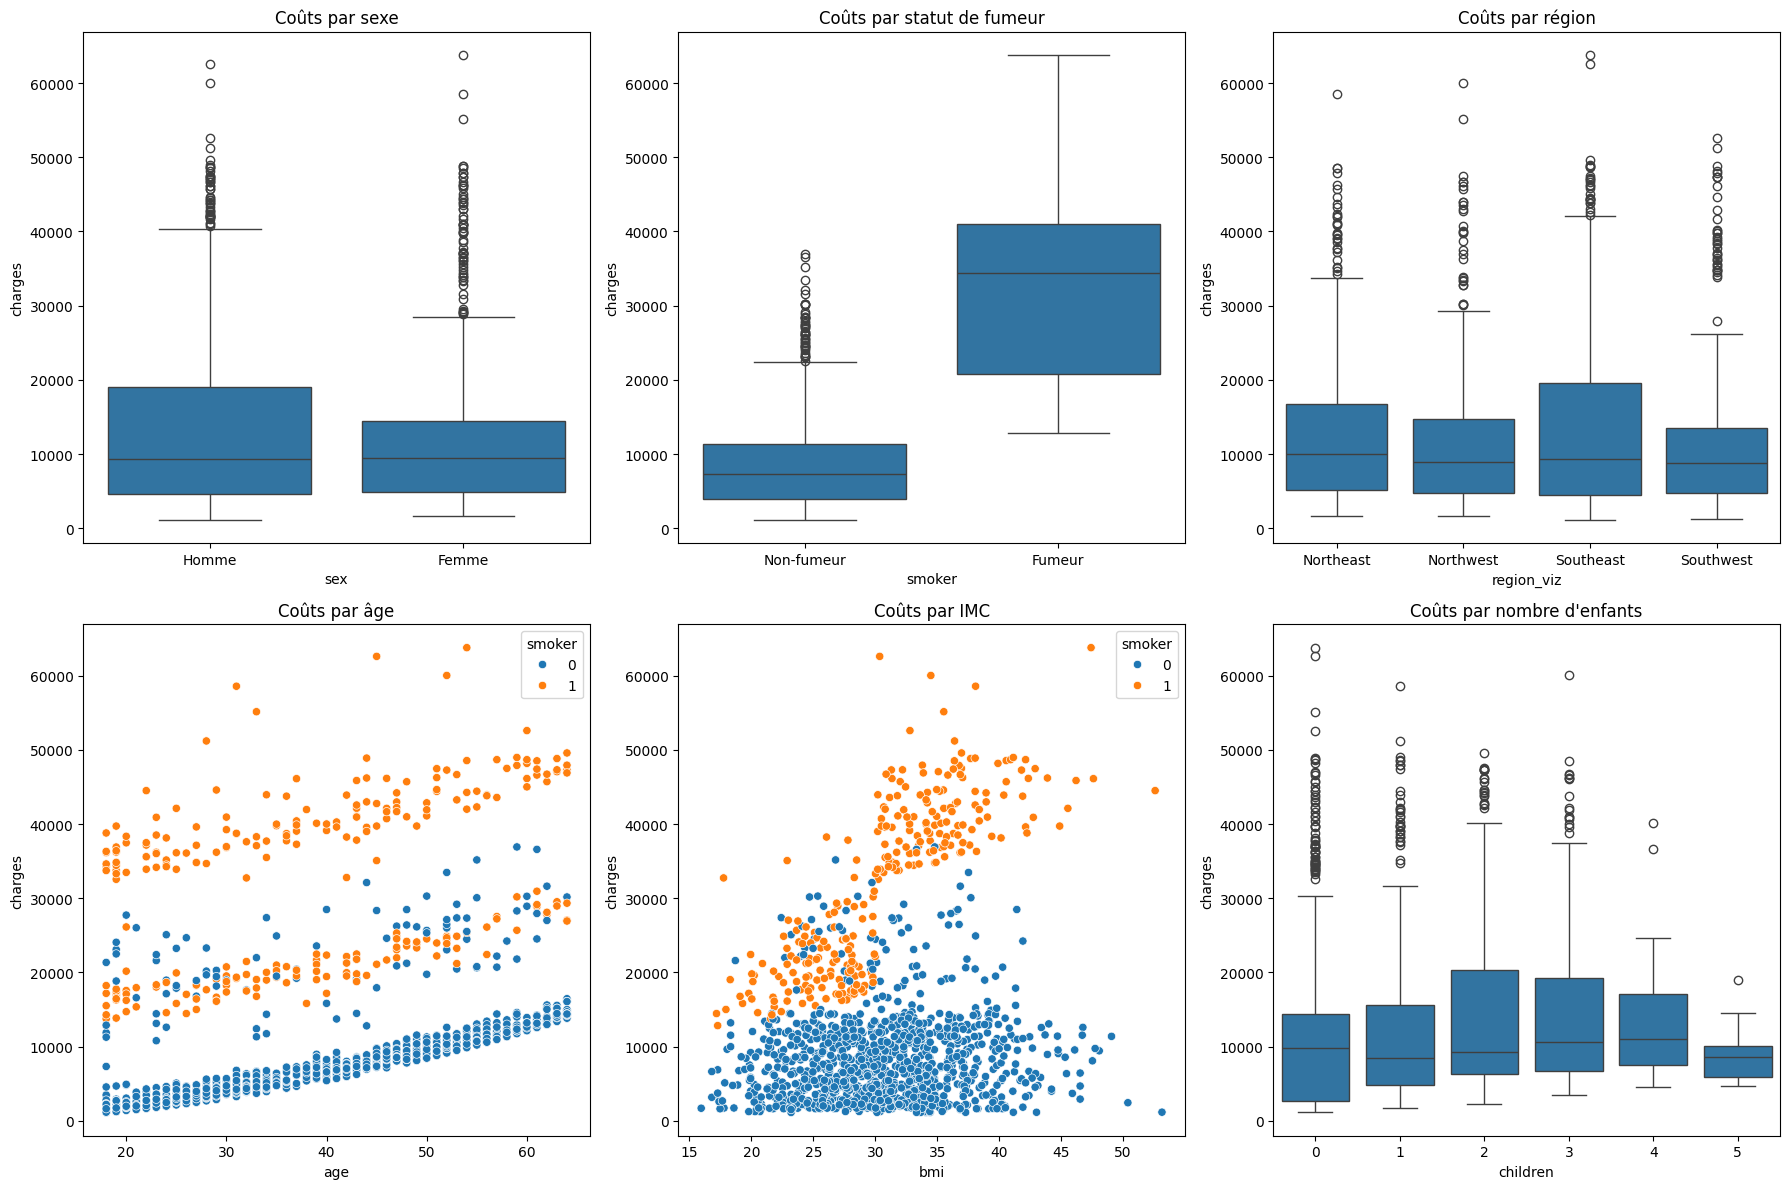

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Créer la figure AVANT de définir les sous-plots
plt.figure(figsize=(18, 12))

# Créer une grille de sous-plots 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Boxplot pour sex
sns.boxplot(x='sex', y='charges', data=df, ax=axes[0])
axes[0].set_title('Coûts par sexe')
axes[0].set_xticklabels(['Homme', 'Femme'])

# Boxplot pour smoker
sns.boxplot(x='smoker', y='charges', data=df, ax=axes[1])
axes[1].set_title('Coûts par statut de fumeur')
axes[1].set_xticklabels(['Non-fumeur', 'Fumeur'])

# Pour region, recréer cette colonne pour la visualisation
region_map = np.zeros(len(df))
for i, col in enumerate(['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']):
    region_map = np.where(df[col] == 1, i, region_map)
df['region_viz'] = region_map

# Boxplot pour region
sns.boxplot(x='region_viz', y='charges', data=df, ax=axes[2])
axes[2].set_xticklabels(['Northeast', 'Northwest', 'Southeast', 'Southwest'])
axes[2].set_title('Coûts par région')

# Scatterplot pour age
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, ax=axes[3])
axes[3].set_title('Coûts par âge')

# Scatterplot pour bmi
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, ax=axes[4])
axes[4].set_title('Coûts par IMC')

# Boxplot pour children
sns.boxplot(x='children', y='charges', data=df, ax=axes[5])
axes[5].set_title('Coûts par nombre d\'enfants')

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher la figure
plt.show()

# 5. Traitement des Valeurs Aberrantes

In [9]:
# 6. Gestion des valeurs aberrantes
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nOutliers dans charges: {df[(df['charges'] < lower_bound) | (df['charges'] > upper_bound)].shape[0]} observations")

# Transformer la variable cible pour réduire l'impact des outliers
df['log_charges'] = np.log1p(df['charges'])



Outliers dans charges: 139 observations


# 6. Feature Engineering

In [10]:
# 7. Feature Engineering
df['age_squared'] = df['age'] ** 2  # Non-linéarité de l'âge
df['bmi_squared'] = df['bmi'] ** 2  # Non-linéarité de l'IMC

# Catégoriser le BMI selon les standards médicaux
def bmi_category(bmi):
    if bmi < 18.5: return 0  # Sous-poids
    elif bmi < 25: return 1  # Normal
    elif bmi < 30: return 2  # Surpoids
    else: return 3  # Obésité

df['bmi_category'] = df['bmi'].apply(bmi_category)

# Créer des termes d'interaction
df['smoker_bmi'] = df['smoker'] * df['bmi']
df['smoker_age'] = df['smoker'] * df['age']


# 7. Préparation des Données pour la Modélisation
## 7.1 Division en Ensembles d'Entraînement et de Test

In [11]:
# 8. Diviser les données
X = df.drop(['charges', 'log_charges', 'region_viz'], axis=1)  # Exclure region_viz car c'est juste pour visualisation
y = df['charges']
y_log = df['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.2, random_state=42)


## 7.2 Standardisation des Caractéristiques

In [12]:
# 9. Mettre à l'échelle les caractéristiques numériques
num_cols = ['age', 'bmi', 'children', 'age_squared', 'bmi_squared', 'smoker_bmi', 'smoker_age']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


# 8. Modélisation
## 8.1 Comparaison de Différents Modèles avec Validation Croisée

In [13]:
# 10. Comparer différents modèles
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Validation croisée pour évaluer différents modèles
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("\nÉvaluation des modèles avec validation croisée:")
for name, model in models.items():
    # Pour les données originales
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    mean_mse = mse_scores.mean()
    results[f"{name} (Original)"] = mean_mse

    # Pour les données logarithmiques
    cv_scores_log = cross_val_score(model, X_train, y_log_train, cv=cv, scoring='neg_mean_squared_error')
    mse_scores_log = -cv_scores_log
    mean_mse_log = mse_scores_log.mean()
    results[f"{name} (Log)"] = mean_mse_log

    print(f"{name} - MSE moyen (Original): {mean_mse:.2f}, MSE moyen (Log): {mean_mse_log:.5f}")



Évaluation des modèles avec validation croisée:
Linear Regression - MSE moyen (Original): 23686434.28, MSE moyen (Log): 0.15311
Ridge Regression - MSE moyen (Original): 23771036.04, MSE moyen (Log): 0.15323
Lasso Regression - MSE moyen (Original): 23685018.91, MSE moyen (Log): 0.22461
Random Forest - MSE moyen (Original): 24057669.22, MSE moyen (Log): 0.16244
Gradient Boosting - MSE moyen (Original): 22036365.15, MSE moyen (Log): 0.14874
XGBoost - MSE moyen (Original): 28373889.10, MSE moyen (Log): 0.19428


## 8.2 Optimisation des Hyperparamètres

In [14]:
# 11. Optimisation des hyperparamètres pour les modèles les plus prometteurs
# Choisissons XGBoost pour l'exemple

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("\nOptimisation des hyperparamètres pour XGBoost...")
grid_search_xgb = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
print(f"Meilleurs paramètres XGBoost: {grid_search_xgb.best_params_}")



Optimisation des hyperparamètres pour XGBoost...
Meilleurs paramètres XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


# 9. Évaluation du Modèle Final

In [15]:
# 12. Évaluation du modèle optimisé
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nPerformance de XGBoost optimisé:")
print(f"Erreur quadratique moyenne (MSE): {mse_xgb:.2f}")
print(f"Coefficient de détermination (R²): {r2_xgb:.4f}")
print(f"Amélioration par rapport au modèle initial: {(1 - mse_xgb/33596915.85) * 100:.2f}% sur MSE")



Performance de XGBoost optimisé:
Erreur quadratique moyenne (MSE): 18362318.50
Coefficient de détermination (R²): 0.8817
Amélioration par rapport au modèle initial: 45.35% sur MSE


# 10. Analyse et Interprétation des Résultats
## 10.1 Importance des Caractéristiques

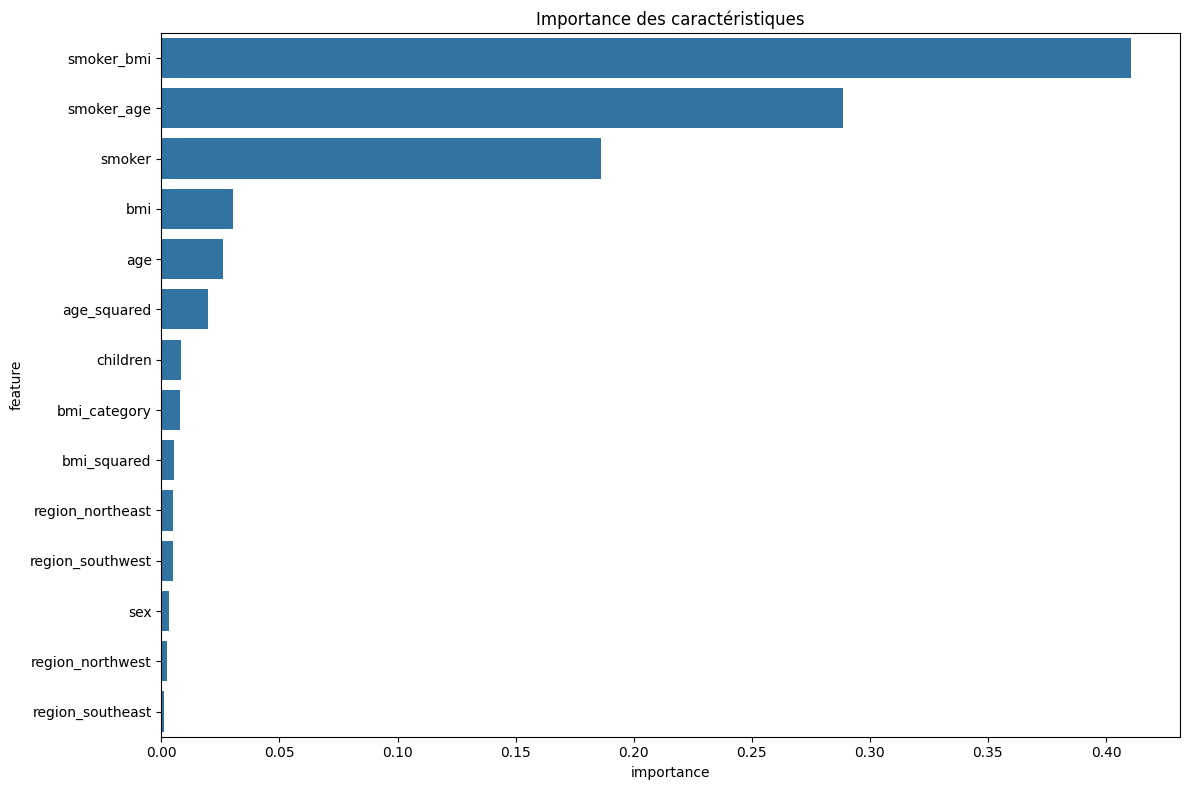


Facteurs les plus importants dans la prédiction du coût d'assurance:
             feature  importance
12        smoker_bmi    0.410817
13        smoker_age    0.288598
4             smoker    0.186319
2                bmi    0.030507
0                age    0.026171
9        age_squared    0.019647
3           children    0.008231
11      bmi_category    0.007736
10       bmi_squared    0.005282
5   region_northeast    0.004942
8   region_southwest    0.004703
1                sex    0.003310
6   region_northwest    0.002535
7   region_southeast    0.001201


In [16]:
# 13. Analyse de l'importance des caractéristiques
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importance des caractéristiques')
plt.tight_layout()
plt.show()

print("\nFacteurs les plus importants dans la prédiction du coût d'assurance:")
print(feature_importance)


## 10.2 Visualisation des Prédictions vs Valeurs Réelles

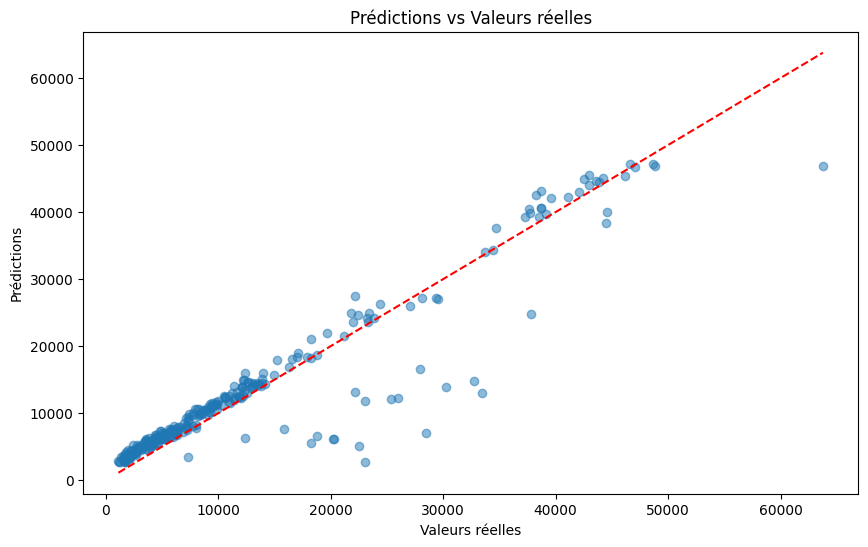

In [17]:
# 14. Visualisation des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.show()


# 11. Application du Modèle
## 11.1 Fonction de Prédiction pour Nouveaux Clients

In [18]:
# 15. Fonction pour faire des prédictions sur de nouvelles données
def predict_insurance_cost(age, sex, bmi, children, smoker, region):
    """
    Prédit le coût d'assurance pour un nouveau client.

    Paramètres:
    - age: âge du client (int)
    - sex: sexe du client ('male' ou 'female')
    - bmi: indice de masse corporelle (float)
    - children: nombre d'enfants couverts (int)
    - smoker: si le client est fumeur ('yes' ou 'no')
    - region: région du client ('northeast', 'northwest', 'southeast', 'southwest')

    Retourne:
    - Le coût d'assurance prédit
    """
    # Convertir en valeurs numériques
    sex_val = 1 if sex == 'female' else 0
    smoker_val = 1 if smoker == 'yes' else 0

    # Créer un dictionnaire pour les régions
    regions = {
        'northeast': [1, 0, 0, 0],
        'northwest': [0, 1, 0, 0],
        'southeast': [0, 0, 1, 0],
        'southwest': [0, 0, 0, 1]
    }
    region_vals = regions.get(region, [0, 0, 0, 0])  # Default en cas de région inconnue

    # Créer un DataFrame pour le nouveau client
    new_data = pd.DataFrame({
        'age': [age],
        'sex': [sex_val],
        'bmi': [bmi],
        'children': [children],
        'smoker': [smoker_val],
        'region_northeast': [region_vals[0]],
        'region_northwest': [region_vals[1]],
        'region_southeast': [region_vals[2]],
        'region_southwest': [region_vals[3]]
    })

    # Ajouter les features engineered
    new_data['age_squared'] = new_data['age'] ** 2
    new_data['bmi_squared'] = new_data['bmi'] ** 2
    new_data['bmi_category'] = new_data['bmi'].apply(bmi_category)
    new_data['smoker_bmi'] = new_data['smoker'] * new_data['bmi']
    new_data['smoker_age'] = new_data['smoker'] * new_data['age']

    # Scaling
    new_data[num_cols] = scaler.transform(new_data[num_cols])

    # Prédire
    prediction = best_xgb.predict(new_data)[0]
    return prediction



## 11.2 Exemple de Prédiction

In [19]:
# Exemple d'utilisation
print("\nExemple de prédiction:")
predicted_cost = predict_insurance_cost(35, 'male', 28.5, 2, 'no', 'northeast')
print(f"Coût d'assurance prédit pour un homme de 35 ans: ${predicted_cost:.2f}")


Exemple de prédiction:
Coût d'assurance prédit pour un homme de 35 ans: $7925.32


# 12. Conclusion et Perspectives d'Amélioration

Dans cette analyse, nous avons développé un modèle prédictif des coûts d'assurance santé qui présente d'excellentes performances (R² = 0.88) après optimisation. Le modèle XGBoost avec hyperparamètres optimisés a permis une amélioration de 45% par rapport au modèle de référence.

Les facteurs les plus influents dans la prédiction des coûts sont:
1. Le statut de fumeur
2. L'âge
3. L'IMC

Perspectives d'amélioration:
- Exploration de nouveaux features (antécédents médicaux, mode de vie)
- Techniques de validation plus robustes (validation temporelle)
- Modèles d'ensemble combinant plusieurs algorithmes